
Convolutional Neural Networks
===============

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.


ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Layers used to build ConvNets:

- INPUT [28x28x1] will hold the raw pixel values of the image, in this case an image of width 28, height 28, and with one color channel.
- CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [28x28x12] if we decided to use 12 filters.
- RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([28x28x12]).
- POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x14x12].
- FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10]

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Load the data

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` . In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a sequence of processing steps built with the `transform` module from `torchvision`. 



### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

```

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a `DataLoader`. The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True)
```

In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load the dataset
dat_dir = r'C:\Users\naras\.spyder-py3\document'
trainset = datasets.ImageFolder(dat_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = datasets.ImageFolder(dat_dir, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

print(testloader.dataset)
print(trainloader.dataset)


Dataset ImageFolder
    Number of datapoints: 1011
    Root location: C:\Users\naras\.spyder-py3\document
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1011
    Root location: C:\Users\naras\.spyder-py3\document
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


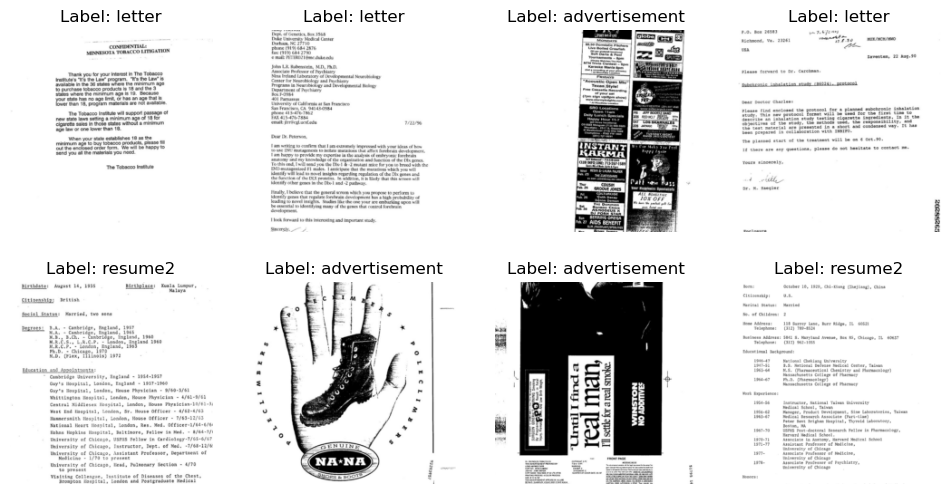

In [3]:
# Visualize some images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use next() directly

fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=4)
for ii, (image, label) in enumerate(zip(images[:8], labels[:8])):
    ax = axes[ii // 4, ii % 4]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'Label: {trainset.classes[label]}')
    ax.axis('off')
plt.show()

Define the network
------------------

Let’s define this network:

Detailed Explanation of the Network (Net Class)
-----------------------------------------------

Network Architecture

Convolutional Layers:

1) conv1: Convolves the input image (3 channels) with 10 filters of size 3x3, stride of 1.
2) conv2: Convolves the output of conv1 with 20 filters of size 3x3.
3) conv3: Convolves the output of conv2 with 30 filters of size 2x2, padding of 1.

Dropout Layers:

conv2_drop: Dropout layer applied after conv2 and conv3 to prevent overfitting.

Fully Connected Layers:

1) fc1: Takes the flattened output from the convolutional layers and outputs 50 features.
2) fc2: Takes 50 features and outputs 30 features.
3) fc3: Takes 30 features and outputs 3 class probabilities.

Functioning of the Network
--------------------------

Convs Method:

1) Convolution and Pooling :  
    Applies convolutional layers followed by max pooling and ReLU activation functions. The _to_linear attribute is calculated to determine the input size for the fully connected layer.

2) Forward Method:

   Convolutional Forward Pass: Passes the input through the convs method.

   Flattening: Flattens the feature maps to a 1D tensor.

   Fully Connected Forward Pass: Passes the flattened tensor through the fully connected layers with dropout applied before the output layer.

   Output: Returns the log softmax probabilities for each class.


Convolutional Layer (conv layer)
--------------------------------

The convolution operation involves the following steps:

1) Sliding the Kernel: The 3x3 kernel slides over the input image, starting from the top-left corner and moving across the image with the specified stride.

2) Computing Dot Products: At each position, the kernel and the corresponding input patch are element-wise multiplied and summed (dot product) to produce a single value in the output feature map.

3) Generating Feature Maps: This process is repeated for all positions of the kernel on the input image, generating a feature map for each output channel. 


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1)  # Change input channels to 3
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=2, padding=1)
        self.conv2_drop = nn.Dropout2d()  # Regularization
        
        # Calculate the size of the input to the first fully connected layer
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 50)  # Adjust input size to fully connected layer
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 3)  # Change output size to 3 for 3 classes

    def convs(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv3(x)), 2))
        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Flatten tensor
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=21870, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


Defining The CNN Network
------------------------

1. `super(Net, self).__init__()`: This calls the initializer of the parent class (nn.Module). It is necessary to properly initialize the neural network module.

2. `self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1)`:

   3: Number of input channels (color image with RGB channels).
   10: Number of output channels (feature maps).
   kernel_size=3: Size of the convolutional filter (3x3).
   stride=1: Step size with which the filter moves across the image.

3. `self.conv2 = nn.Conv2d(10, 20, kernel_size=3)`:

   10: Number of input channels (from previous layer).
   20: Number of output channels.
   kernel_size=3: Size of the convolutional filter (3x3).

4. `self.conv3 = nn.Conv2d(20, 30, kernel_size=2, padding=1)`:

   20: Number of input channels (from previous layer).
   30: Number of output channels.
   kernel_size=2: Size of the convolutional filter (2x2).
   padding=1: Adds padding around the input to keep the output size similar.

5. `self.conv2_drop = nn.Dropout2d()`: Adds dropout regularization to reduce overfitting by randomly setting some activations to zero during training.

6. `self._to_linear = None`: A placeholder to store the size of the tensor after the convolutional layers, which is required for the fully connected layer.

7. `self.convs(torch.randn(1, 3, 224, 224))`: Passes a dummy tensor through the convolutional layers to calculate and store the size of the tensor that will be input to the fully connected layer.

8. `self.fc1 = nn.Linear(self._to_linear, 50)`:

   `self._to_linear`: The size of the flattened tensor after the convolutional layers.
   50: Number of neurons in the first fully connected layer.

9. `self.fc2 = nn.Linear(50, 30)`: Defines the second fully connected layer with 50 input neurons and 30 output neurons.

10. `self.fc3 = nn.Linear(30, 3)`: Defines the final fully connected layer with 30 input neurons and 3 output neurons (for 3 classes).

Convolutional and Pooling Layers
--------------------------------

1. `x = F.relu(F.max_pool2d(self.conv1(x), 2))`:

   Passes the input x through the first convolutional layer (self.conv1).
   Applies a ReLU activation function.
   Applies 2x2 max pooling to reduce the spatial dimensions by half.

2. `x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))`:

   Passes x through the second convolutional layer (self.conv2).
   Applies dropout regularization.
   Applies ReLU activation.
   Applies 2x2 max pooling.

3. `x = F.relu(F.max_pool2d(self.conv2_drop(self.conv3(x)), 2))`:

   Passes x through the third convolutional layer (self.conv3).
   Applies dropout regularization.
   Applies ReLU activation.
   Applies 2x2 max pooling.

4. `if self._to_linear is None:`:

   Calculates the flattened size of the tensor after the convolutional layers using x.view(-1).shape[0] and stores it in self._to_linear.

5. `return x`: Returns the processed tensor x.

Forword Pass
------------

1. `x = self.convs(x)`: Passes the input x through the convolutional and pooling layers defined in convs.

2. `x = x.view(-1, self._to_linear)`: Flattens the output tensor from the convolutional layers into a 1D tensor with size self._to_linear.

3. `x = F.relu(self.fc1(x))`: Passes the flattened tensor through the first fully connected layer (self.fc1) and applies a ReLU activation function.

4. `x = F.dropout(x, training=self.training)`: Applies dropout regularization to the output of the first fully connected layer during training.

5. `x = self.fc2(x)`: Passes the tensor through the second fully connected layer (self.fc2).

6. `x = F.dropout(x, training=self.training)`: Applies dropout regularization to the output of the second fully connected layer during training.

7. `x = self.fc3(x)`: Passes the tensor through the final fully connected layer (self.fc3).

8. `return F.log_softmax(x, dim=1)`: Applies the log-softmax activation function to the output, producing log-probabilities for each class.

Optimizer
---------

Explanation 

`optim.SGD`: This creates an optimizer for the model using Stochastic Gradient Descent (SGD). SGD is a type of gradient descent algorithm used for optimizing the model's parameters (weights).

`net.parameters()`: This is a method that returns all the parameters of the network (weights and biases) that need to be updated during training.

`lr=0.01`: This sets the learning rate to 0.01. The learning rate is a hyperparameter that controls how much to change the model's parameters in response to the estimated error each time the model's weights are updated.

Loss Function
-------------

Explanation

`nn.NLLLoss`: This specifies the loss function to be Negative Log-Likelihood Loss, which is often used in classification problems. This loss function expects the input to be log probabilities, which is why the final layer of your network uses `F.log_softmax`.


In [5]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [6]:
epochs = 15
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train() 
    for images, labels in trainloader:
        # Clear the gradients
        optimizer.zero_grad() 
        # Forward pass, get our logits
        log_ps = net(images) 
        # Calculate the loss with the logits and the labels
        loss = criterion(log_ps, labels)
        # Calculate the gradients
        loss.backward() 
        # Update the weights
        optimizer.step() 
         
        running_loss += loss.item() 
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad(): 
            for images, labels in testloader:
                log_ps = net(images)
                test_loss += criterion(log_ps, labels).item()
                
                ps = torch.exp(log_ps) 
                top_p, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print(f"Epoch: {e+1}/{epochs}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Test Loss: {test_loss/len(testloader):.3f}.. "
              f"Test Accuracy: {accuracy/len(testloader):.3f}")

Epoch: 1/15.. Training Loss: 1.106.. Test Loss: 1.099.. Test Accuracy: 0.362
Epoch: 2/15.. Training Loss: 1.101.. Test Loss: 1.098.. Test Accuracy: 0.358
Epoch: 3/15.. Training Loss: 1.100.. Test Loss: 1.096.. Test Accuracy: 0.362
Epoch: 4/15.. Training Loss: 1.100.. Test Loss: 1.096.. Test Accuracy: 0.361
Epoch: 5/15.. Training Loss: 1.101.. Test Loss: 1.094.. Test Accuracy: 0.362
Epoch: 6/15.. Training Loss: 1.097.. Test Loss: 1.094.. Test Accuracy: 0.362
Epoch: 7/15.. Training Loss: 1.095.. Test Loss: 1.094.. Test Accuracy: 0.363
Epoch: 8/15.. Training Loss: 1.096.. Test Loss: 1.093.. Test Accuracy: 0.360
Epoch: 9/15.. Training Loss: 1.096.. Test Loss: 1.091.. Test Accuracy: 0.361
Epoch: 10/15.. Training Loss: 1.091.. Test Loss: 1.090.. Test Accuracy: 0.362
Epoch: 11/15.. Training Loss: 1.095.. Test Loss: 1.090.. Test Accuracy: 0.362
Epoch: 12/15.. Training Loss: 1.094.. Test Loss: 1.089.. Test Accuracy: 0.363
Epoch: 13/15.. Training Loss: 1.094.. Test Loss: 1.088.. Test Accuracy: 0

Training Loop
-------------

1. `optimizer.zero_grad()`: Clears the old gradients.

2. `log_ps = net(images)`: Forward pass, calculates the predicted log probabilities.

3. `loss = criterion(log_ps, labels)`: Computes the loss between    predictions and actual labels.

4. `loss.backward()`: Backward pass, calculates the gradients.

5. `optimizer.step()`: Updates the weights based on gradients.

6. `running_loss += loss.item()`: Accumulates the training loss.

Evaluation Phase
----------------

1. `net.eval()`: Sets the network to evaluation mode.

2. `with torch.no_grad():`: Disables gradient calculation to save memory.
3. `log_ps = net(images)`: Forward pass for test data.

4. `test_loss += criterion(log_ps, labels).item()`: Computes and accumulates test loss.

5. `ps = torch.exp(log_ps)`: Converts log probabilities to probabilities.

6. `top_p, top_class = ps.topk(1, dim=1)`: Gets the predicted class.

7. `equals = top_class == labels.view(*top_class.shape)`: Compares predictions with actual labels.

8. `accuracy += torch.mean(equals.type(torch.FloatTensor)).item()`: Calculates and accumulates accuracy.

Results
-------

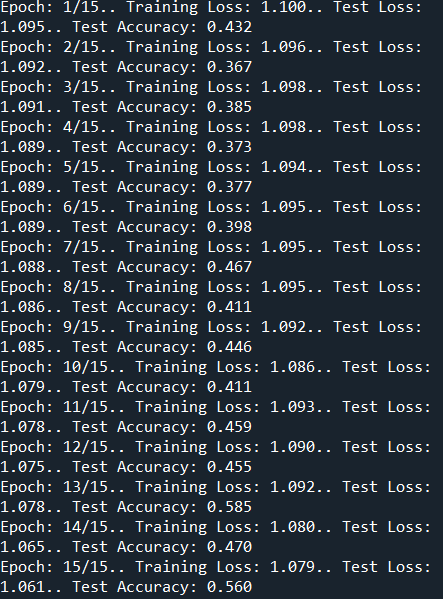

Ploting The Results
-------------------

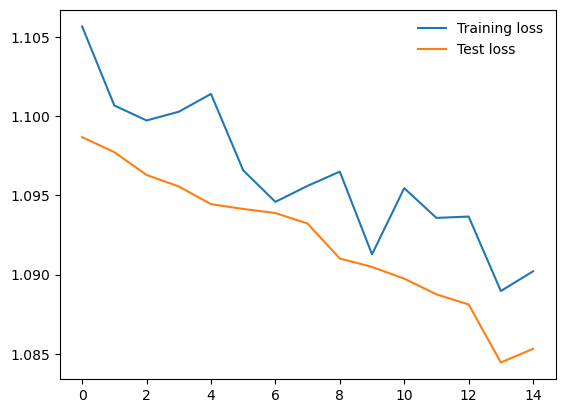

In [7]:
# Plotting training and test losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()